In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import DistanceMetric
from scipy.spatial.distance import mahalanobis
import os
import sys
from PIL import Image
sys.path.append('../models')
import ResNet as resnet
import DenseNet as densenet
import EfficientNet as efficientnet
import MobileNetV2 as mobilenet
import ViT as vit

import seaborn as sns

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2, 3"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
##########################################
######### Configure Metric Setting ####### 
##########################################
batch_size = 64
weight_path = './weights/cifar10_resnet18_base.pt'
model_base = torch.load(weight_path)
weight_path = './weights/cifar10_resnet18_v3.pt'
model_private = torch.load(weight_path)
criterion = nn.CrossEntropyLoss()
label = 'airplane/'
member_path = '/media/data1/hyunjun/cifar-10/train/' + label
nonmember_path = '/media/data1/hyunjun/cifar-10/test/' + label
data = 'Cifar-10'
##########################################
##########################################

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.root_dir = root_dir
        
        self.image_paths = []
        for data_path in os.listdir(root_dir):
            self.image_paths.append(data_path)
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image_file_path = os.path.join(self.root_dir, self.image_paths[index])
        image = Image.open(image_file_path)
        
        label = 0
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label

In [5]:
mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225) 
if data == 'STL-10':
    mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
elif data == 'Cifar-10':
    mean, std = (0.491, 0.482, 0.447), (0.247, 0.243, 0.262)
elif data == 'CelebA':
    mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)

trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

model_base.to(device)
model_base.eval()
model_private.to(device)
model_private.eval()

# nonmember_set = CustomDataset(root_dir=nonmember_path, transform=trans)
# nonmember_loader = DataLoader(nonmember_set, batch_size=batch_size, shuffle=True, drop_last=False,)
member_set = CustomDataset(root_dir=member_path, transform=trans)
member_loader = DataLoader(member_set, batch_size=batch_size, shuffle=True, drop_last=False,)

In [6]:
latent_vectors_base = []
latent_vectors_private = []

with torch.no_grad():
    for data in member_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features, _ = model_base(images)

        latent_vectors_base += features.cpu().numpy().tolist()
        
    for data in member_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features, _ = model_private(images)

        latent_vectors_private += features.cpu().numpy().tolist()

#####################################
### Calculating Cosine Similarity ###
#####################################
max: 1.0000, min: 0.3268, mean: 0.8714, var: 0.0049
max: 1.0000, min: 0.1462, mean: 0.8224, var: 0.0114


/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  if __name__ == '__main__':
/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # Remove the CWD from sys.pa

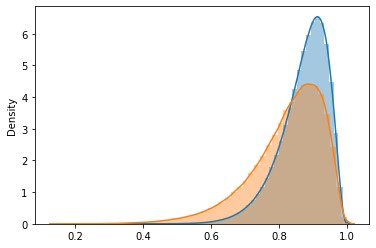

In [7]:
print("#####################################")
print("### Calculating Cosine Similarity ###")
print("#####################################")
cssm_base = cosine_similarity(np.array(latent_vectors_base))
print(f"max: {np.max(cssm_base):.4f}, min: {np.min(cssm_base):.4f}, mean: {np.mean(cssm_base):.4f}, var: {np.var(cssm_base):.4f}")
cssm_private = cosine_similarity(np.array(latent_vectors_private))
print(f"max: {np.max(cssm_private):.4f}, min: {np.min(cssm_private):.4f}, mean: {np.mean(cssm_private):.4f}, var: {np.var(cssm_private):.4f}")

sns.distplot(cssm_base)
sns.distplot(cssm_private)
plt.show()

#####################################
## Calculating Euclidean Distance ###
#####################################
max: 40.7751, min: 0.0000, mean: 15.6597, var: 19.2854
max: 45.5062, min: 0.0000, mean: 17.5716, var: 28.5941


/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # Remove the CWD from sys.path while we load stuff.
/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # 

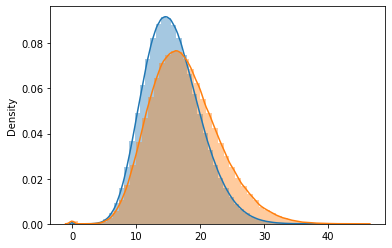

In [8]:
print("#####################################")
print("## Calculating Euclidean Distance ###")
print("#####################################")
dist = DistanceMetric.get_metric('euclidean')
euclidean_base = dist.pairwise(np.array(latent_vectors_base))
print(f"max: {np.max(euclidean_base):.4f}, min: {np.min(euclidean_base):.4f}, mean: {np.mean(euclidean_base):.4f}, var: {np.var(euclidean_base):.4f}")
euclidean_private = dist.pairwise(np.array(latent_vectors_private))
print(f"max: {np.max(euclidean_private):.4f}, min: {np.min(euclidean_private):.4f}, mean: {np.mean(euclidean_private):.4f}, var: {np.var(euclidean_private):.4f}")

sns.distplot(euclidean_base)
sns.distplot(euclidean_private)
plt.show()

#####################################
## Calculating Manhattan Distance ###
#####################################
max: 117.6883, min: 0.0000, mean: 40.7377, var: 144.7012
max: 121.2812, min: 0.0000, mean: 45.3522, var: 201.1604


/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # Remove the CWD from sys.path while we load stuff.
/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # 

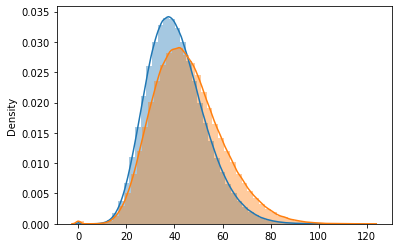

In [9]:
print("#####################################")
print("## Calculating Manhattan Distance ###")
print("#####################################")
dist = DistanceMetric.get_metric('manhattan')
manhattan_base = dist.pairwise(np.array(latent_vectors_base))
print(f"max: {np.max(manhattan_base):.4f}, min: {np.min(manhattan_base):.4f}, mean: {np.mean(manhattan_base):.4f}, var: {np.var(manhattan_base):.4f}")
manhattan_private = dist.pairwise(np.array(latent_vectors_private))
print(f"max: {np.max(manhattan_private):.4f}, min: {np.min(manhattan_private):.4f}, mean: {np.mean(manhattan_private):.4f}, var: {np.var(manhattan_private):.4f}")

sns.distplot(manhattan_base)
sns.distplot(manhattan_private)
plt.show()

#####################################
## Calculating Chebyshev Distance ###
#####################################
max: 30.1406, min: 0.0000, mean: 9.4493, var: 8.6765
max: 36.4540, min: 0.0000, mean: 10.7718, var: 13.8057


/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # Remove the CWD from sys.path while we load stuff.
/home/hyunjun/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  # 

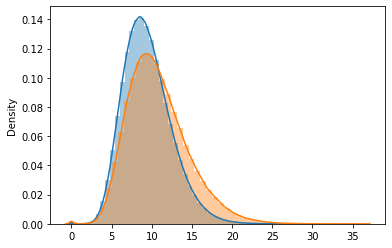

In [10]:
print("#####################################")
print("## Calculating Chebyshev Distance ###")
print("#####################################")
dist = DistanceMetric.get_metric('chebyshev')
chebyshev_base = dist.pairwise(np.array(latent_vectors_base))
print(f"max: {np.max(chebyshev_base):.4f}, min: {np.min(chebyshev_base):.4f}, mean: {np.mean(chebyshev_base):.4f}, var: {np.var(chebyshev_base):.4f}")
chebyshev_private = dist.pairwise(np.array(latent_vectors_private))
print(f"max: {np.max(chebyshev_private):.4f}, min: {np.min(chebyshev_private):.4f}, mean: {np.mean(chebyshev_private):.4f}, var: {np.var(chebyshev_private):.4f}")

sns.distplot(chebyshev_base)
sns.distplot(chebyshev_private)
plt.show()